In [17]:
import numpy as np
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import brier_score_loss
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.feature_selection import chi2
from sklearn.model_selection import GridSearchCV, LeaveOneOut, StratifiedKFold, KFold

In [2]:
with open(r'C:\Users\Axel\Desktop\projet stat\bdd\liste_texte_oui.txt', 'r') as f:
    liste_texte_oui = f.read().splitlines()
    
with open(r'C:\Users\Axel\Desktop\projet stat\bdd\liste_question.txt', 'r') as f:
    liste_question = f.read().splitlines()
    
data_train_clean= pd.read_csv(r'C:\Users\Axel\Desktop\projet stat\bdd\data_train_clean.csv')
data_train_clean.set_index('node_id',inplace=True)

In [3]:
len(liste_texte_oui), len(liste_question),len(data_train_clean)

(1488, 775, 423)

In [4]:
dico_param_random_forest=dict.fromkeys(liste_texte_oui,None)
dico_accurency_train_random_forest=dict.fromkeys(liste_texte_oui,None)
dico_recall_train_random_forest=dict.fromkeys(liste_texte_oui,None)
dico_accurency_test_random_forest=dict.fromkeys(liste_texte_oui,None)
dico_recall_test_random_forest=dict.fromkeys(liste_texte_oui,None)

In [5]:
#A noter: liste texte_oui et liste_question doivent etre défini précédement
def equilibre(data,i):
    if isinstance(i, str):
        text=i
    else: 
        text = liste_texte_oui[i]
    
    #creation base
    colonnes = list(liste_question)
    colonnes.append(text)
    base_text = data[list(colonnes)]
    
    #creation test set et train set
    X_train, X_test, Y_train, Y_test = train_test_split(base_text.iloc[:,0:-1], base_text[text],stratify=base_text[text], test_size=0.2,random_state=10)    
    
    # Returning to one dataframe
    training_set = pd.concat([X_train, Y_train], axis=1)
    
    # Separating classes
    class1 = training_set[training_set[text] == 1]
    class0 = training_set[training_set[text] == 0]
    
    #taille des classes
    n0=len(class0)
    n1=len(class1)
    
    if n0 > n1 :
        undersample = resample(class0, replace=True, n_samples=len(class1), random_state=10)
        undersample_train = pd.concat([class1, undersample])
        x_train = undersample_train.drop(text, axis=1)
        y_train = undersample_train[text]
        return (x_train, X_test, y_train, Y_test)
    elif n0 < n1 :
        undersample = resample(class1, replace=True, n_samples=len(class0), random_state=10)
        undersample_train = pd.concat([class0, undersample])
        x_train = undersample_train.drop(text, axis=1)
        y_train = undersample_train[text]
        return (x_train, X_test, y_train, Y_test)
    else:
        return (X_train, X_test, Y_train, Y_test)
    
    
    

In [6]:
x_train, X_test, y_train, Y_test=equilibre(data_train_clean,'ff8081816f2e2090016f5781827a445d')

In [7]:
y_train.value_counts()

1    66
0    66
Name: ff8081816f2e2090016f5781827a445d, dtype: int64

In [8]:
Y_test.value_counts()

1    68
0    17
Name: ff8081816f2e2090016f5781827a445d, dtype: int64

{'max_depth': 9, 'n_estimators': 200}
score apprentissage:1.0
score brier app:0.02942158226046723
score recall test:0.6323529411764706
score accurency test:0.6985294117647058
AUC recall-prec test:0.9386613762846583
score brier test:0.2059651319824085
16.384913206100464


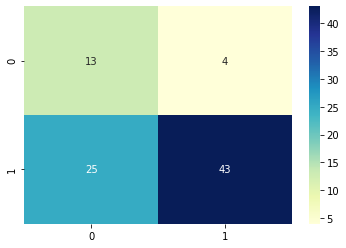

In [9]:
tps1 = time.time()
model=RandomForestClassifier(max_features='auto',random_state=0,n_jobs=-1)

param={'n_estimators':[50,100,200],'max_depth':[3,5,9]}
grid=GridSearchCV(model,param,cv=KFold(n_splits=5, shuffle=True,random_state=0),scoring='average_precision',n_jobs=-1)
grid.fit(x_train,y_train)
print(grid.best_params_)
model1=grid.best_estimator_


print("score apprentissage:{}".format(recall_score(y_train,model1.predict(x_train)))) 
print("score brier app:{}".format(brier_score_loss(y_train,model1.predict_proba(x_train)[:,1])))
print("score recall test:{}".format(recall_score(Y_test,model1.predict(X_test)))) 
print("score accurency test:{}".format(balanced_accuracy_score(Y_test,model1.predict(X_test))))
print("AUC recall-prec test:{}".format(average_precision_score(Y_test,model1.predict_proba(X_test)[:,1]))) 
print("score brier test:{}".format(brier_score_loss(Y_test,model1.predict_proba(X_test)[:,1])))





mat=confusion_matrix(Y_test, model1.predict(X_test))
sns.heatmap(mat,annot=True, fmt="d",cmap="YlGnBu")
tps2 = time.time()
print(tps2 - tps1)

In [10]:
pred_proba_df = pd.DataFrame(model1.predict_proba(X_test))
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
Y_test=pd.DataFrame(Y_test)
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy = accuracy_score(Y_test,Y_test_pred[1])
    
    print('Our testing accuracy is {}'.format(test_accuracy))

    print(confusion_matrix(Y_test,Y_test_pred[1]))


******** For i = 0.05 ******
Our testing accuracy is 0.8
[[ 0 17]
 [ 0 68]]

******** For i = 0.1 ******
Our testing accuracy is 0.8
[[ 0 17]
 [ 0 68]]

******** For i = 0.15 ******
Our testing accuracy is 0.8
[[ 0 17]
 [ 0 68]]

******** For i = 0.2 ******
Our testing accuracy is 0.8
[[ 0 17]
 [ 0 68]]

******** For i = 0.25 ******
Our testing accuracy is 0.8117647058823529
[[ 1 16]
 [ 0 68]]

******** For i = 0.3 ******
Our testing accuracy is 0.7764705882352941
[[ 1 16]
 [ 3 65]]

******** For i = 0.35 ******
Our testing accuracy is 0.8
[[ 5 12]
 [ 5 63]]

******** For i = 0.4 ******
Our testing accuracy is 0.7411764705882353
[[ 7 10]
 [12 56]]

******** For i = 0.45 ******
Our testing accuracy is 0.6588235294117647
[[11  6]
 [23 45]]

******** For i = 0.5 ******
Our testing accuracy is 0.6588235294117647
[[13  4]
 [25 43]]

******** For i = 0.55 ******
Our testing accuracy is 0.5882352941176471
[[16  1]
 [34 34]]

******** For i = 0.6 ******
Our testing accuracy is 0.5764705882352

In [63]:
def seuil(model,seuil_FN,X_test,Y_test):
    nombre0=Y_test.iloc[:,0].value_counts()[0]
    print(nombre0)
    treshold_list = np.arange(0,1,0.05)
    Y_pred_proba = pd.DataFrame(model.predict_proba(X_test))
    Y_test_df = pd.DataFrame(Y_test)
    e = 0
    seuil = 0
    for i in treshold_list:
        print(i)
        Y_pred = Y_pred_proba.applymap(lambda x: 1 if x > i else 0)
        Y_pred = Y_pred.drop(Y_pred.columns[0], axis=1)
        nb0=len(Y_pred.loc[Y_pred[1]==0])
        print(nb0)
        recall = recall_score(Y_test, Y_pred, zero_division = 'warn')
        if 1-recall <= seuil_FN and nb0 >= e:
            e = nb0
            seuil = i
        else: break
    return('recall : {}'.format(recall),
         ' specificité : {}'.format(e/nombre0),
         'le seuil optimal est : {}'.format(round(seuil,2)))

In [35]:
Y_pred_proba = pd.DataFrame(model1.predict_proba(X_test))
Y_pred = Y_pred_proba.applymap(lambda x: 1 if x > 0.25 else 0)
Y_pred = Y_pred.drop(Y_pred.columns[0], axis=1)
len(Y_pred.loc[Y_pred[1]==0])

1

In [54]:
treshold_list = np.arange(0,1,0.05)
treshold_list

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [64]:
seuil(model1,0.01,X_test,Y_test)

17
0.0
0
0.05
0
0.1
0
0.15000000000000002
0
0.2
0
0.25
1
0.30000000000000004
4


('recall : 0.9558823529411765',
 ' specificité : 0.058823529411764705',
 'le seuil optimal est : 0.25')

{'base_estimator__n_neighbors': 3, 'max_features': 0.05}
score apprentissage:0.8939393939393939
score brier app:0.0972273569023569
score recall test:0.6323529411764706
score accurency test:0.6985294117647058
AUC recall-prec test:0.9288152628915545
score brier test:0.21981424836601315
18.35791802406311


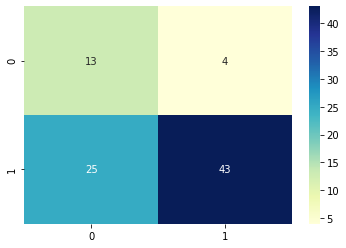

In [11]:
tps1 = time.time()
model=BaggingClassifier(base_estimator=KNeighborsClassifier(),random_state=0,n_estimators=100,n_jobs=-1)
max_feat=[0.05,0.4,0.7]

param={ 'base_estimator__n_neighbors':[3,5],'max_features':max_feat}
grid=GridSearchCV(model,param,cv=StratifiedKFold(n_splits=5, shuffle=True,random_state=0),scoring='neg_brier_score',n_jobs=-1)
grid.fit(x_train,y_train)
para_mod=grid.best_params_

print(para_mod)
model1=grid.best_estimator_


print("score apprentissage:{}".format(recall_score(y_train,model1.predict(x_train)))) 
print("score brier app:{}".format(brier_score_loss(y_train,model1.predict_proba(x_train)[:,1])))
print("score recall test:{}".format(recall_score(Y_test,model1.predict(X_test)))) 
print("score accurency test:{}".format(balanced_accuracy_score(Y_test,model1.predict(X_test))))
print("AUC recall-prec test:{}".format(average_precision_score(Y_test,model1.predict_proba(X_test)[:,1]))) 
print("score brier test:{}".format(brier_score_loss(Y_test,model1.predict_proba(X_test)[:,1])))

mat=confusion_matrix(Y_test, model1.predict(X_test))
sns.heatmap(mat,annot=True, fmt="d",cmap="YlGnBu")
tps2 = time.time()
print(tps2 - tps1)

In [40]:
pred_proba_df = pd.DataFrame(model1.predict_proba(X_test))
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
Y_test=pd.DataFrame(Y_test)
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy = accuracy_score(Y_test,Y_test_pred[1])
    
    print('Our testing accuracy is {}'.format(test_accuracy))

    print(confusion_matrix(Y_test,Y_test_pred[1]))


******** For i = 0.05 ******
Our testing accuracy is 0.8
[[ 0 17]
 [ 0 68]]

******** For i = 0.1 ******
Our testing accuracy is 0.8
[[ 0 17]
 [ 0 68]]

******** For i = 0.15 ******
Our testing accuracy is 0.8
[[ 0 17]
 [ 0 68]]

******** For i = 0.2 ******
Our testing accuracy is 0.8117647058823529
[[ 1 16]
 [ 0 68]]

******** For i = 0.25 ******
Our testing accuracy is 0.8117647058823529
[[ 2 15]
 [ 1 67]]

******** For i = 0.3 ******
Our testing accuracy is 0.8235294117647058
[[ 4 13]
 [ 2 66]]

******** For i = 0.35 ******
Our testing accuracy is 0.8
[[ 6 11]
 [ 6 62]]

******** For i = 0.4 ******
Our testing accuracy is 0.7294117647058823
[[ 7 10]
 [13 55]]

******** For i = 0.45 ******
Our testing accuracy is 0.6705882352941176
[[10  7]
 [21 47]]

******** For i = 0.5 ******
Our testing accuracy is 0.6352941176470588
[[15  2]
 [29 39]]

******** For i = 0.55 ******
Our testing accuracy is 0.5647058823529412
[[16  1]
 [36 32]]

******** For i = 0.6 ******
Our testing accuracy is 

In [16]:
model1.predict_proba(X_test)[:,1]

array([0.70666667, 0.45      , 0.72      , 0.47333333, 0.38666667,
       0.42      , 0.63666667, 0.66666667, 0.67333333, 0.77      ,
       0.63333333, 0.36      , 0.38666667, 0.32      , 0.58666667,
       0.59333333, 0.91666667, 0.62666667, 0.63333333, 0.63333333,
       0.57333333, 0.64      , 0.29      , 0.68333333, 0.54      ,
       0.66      , 0.71666667, 0.36      , 0.71333333, 0.31666667,
       0.47333333, 0.51333333, 0.54333333, 0.48      , 0.69      ,
       0.3       , 0.31333333, 0.42333333, 0.44666667, 0.47333333,
       0.26333333, 0.55      , 0.37      , 0.34666667, 0.37      ,
       0.38666667, 0.68333333, 0.51      , 0.43      , 0.54666667,
       0.61      , 0.55333333, 0.68      , 0.79666667, 0.56      ,
       0.48      , 0.45333333, 0.67      , 0.33666667, 0.86666667,
       0.34333333, 0.47333333, 0.62333333, 0.41333333, 0.38666667,
       0.43666667, 0.27333333, 0.51      , 0.65666667, 0.51666667,
       0.50666667, 0.53666667, 0.30333333, 0.64333333, 0.55666

In [13]:
from sklearn.calibration import calibration_curve


def plot_calibration_curve(name, fig_index, probs):
    """Plot calibration curve for est w/o and with calibration. """

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    
    frac_of_pos, mean_pred_value = calibration_curve(Y_test, probs, n_bins=10)

    ax1.plot(mean_pred_value, frac_of_pos, "s-", label=f'{name}')
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title(f'Calibration plot ({name})')
    
    ax2.hist(probs, range=(0, 1), bins=10, label=name, histtype="step", lw=2)
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")

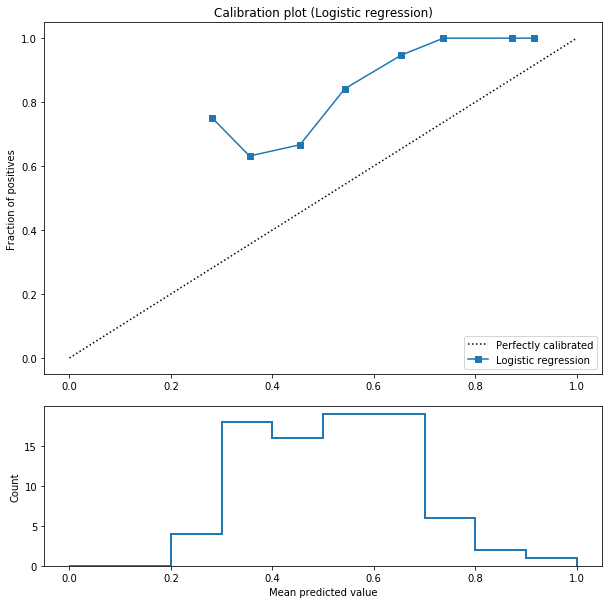

In [18]:
probs_lgr = model1.predict_proba(X_test)[:,1]
# plot calibration curve for logistic regression
plot_calibration_curve("Logistic regression", 1, probs_lgr)

In [44]:
para_mod

{'base_estimator__n_neighbors': 1, 'max_features': 0.05}

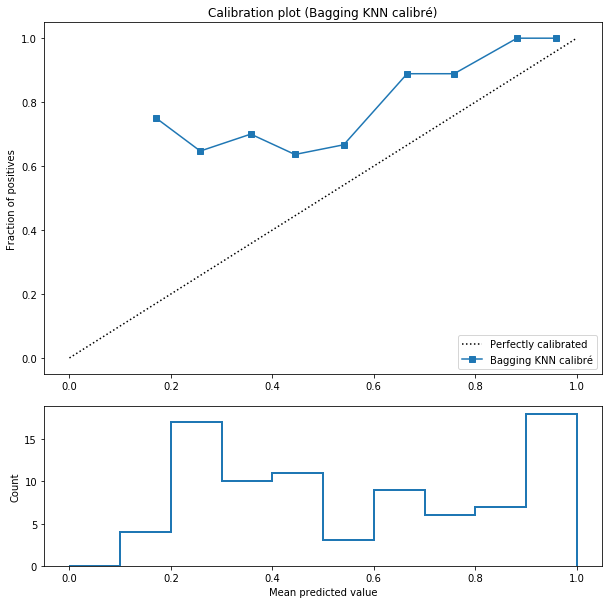

In [22]:
model=BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=para_mod['base_estimator__n_neighbors']),random_state=0,n_estimators=100,max_features=para_mod['max_features'],n_jobs=-1)
calibre = CalibratedClassifierCV(model, cv=StratifiedKFold(n_splits=5, shuffle=True,random_state=0), method='sigmoid')

calibre.fit(x_train, y_train)

calibrated_probs = calibre.predict_proba(X_test)[:,1]

plot_calibration_curve("Bagging KNN calibré", 2, calibrated_probs)
plt.show()

score apprentissage:0.9242424242424242
score test:0.5882352941176471
AUC recall-prec test:0.9285298019487476
brier test:0.21089735755525957


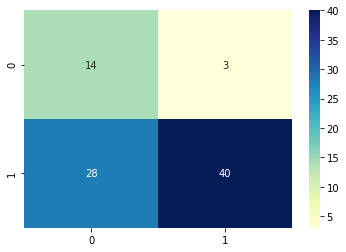

In [23]:
print("score apprentissage:{}".format(recall_score(y_train,calibre.predict(x_train))))           
print("score test:{}".format(recall_score(Y_test,calibre.predict(X_test)))) 
print("AUC recall-prec test:{}".format(average_precision_score(Y_test,calibre.predict_proba(X_test)[:,1]))) 
print("brier test:{}".format(brier_score_loss(Y_test,calibre.predict_proba(X_test)[:,1])))

mat=confusion_matrix(Y_test, calibre.predict(X_test))
sns.heatmap(mat,annot=True, fmt="d",cmap="YlGnBu")


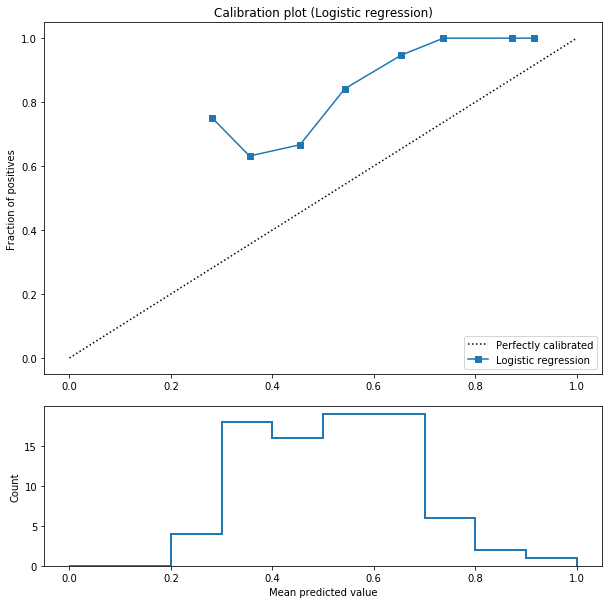

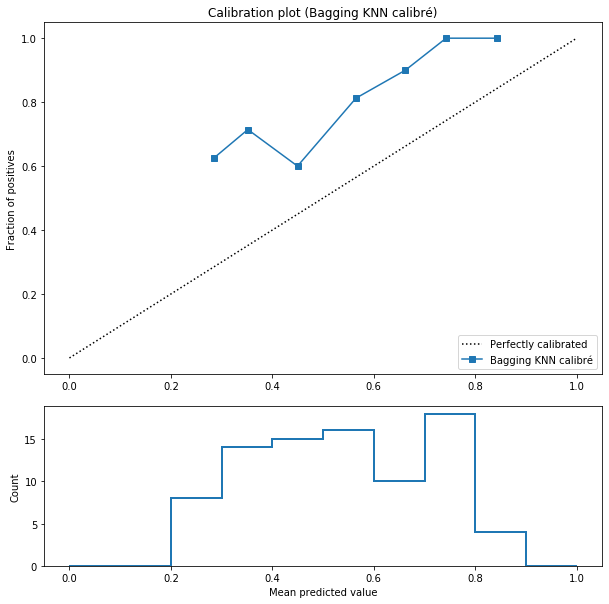

In [22]:

plot_calibration_curve("Logistic regression", 1, probs_lgr)
plot_calibration_curve("Bagging KNN calibré", 2, calibrated_probs)
plt.show()

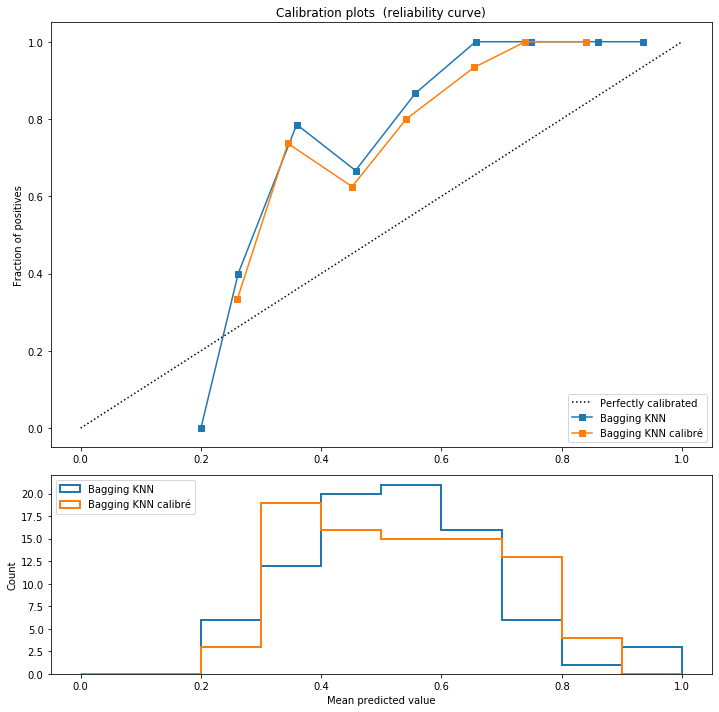

In [45]:

# #############################################################################
# Plot calibration plots

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(model1, 'Bagging KNN'),
                  (calibre, 'Bagging KNN calibré')]:
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(Y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper left", ncol=1)

plt.tight_layout()
plt.show()

In [ ]:
def seuil(model,seuil_FN):
    treshold_list = np.arange(0,1,0.01)
    model.fit(X_train, Y_train)
    Y_pred_proba = pd.DataFrame(model.predict_proba(X_test))
    Y_test_df = pd.DataFrame(Y_test)
    e = 1
    seuil = 0
    for i in treshold_list:
        Y_pred = Y_pred_proba.applymap(lambda x: 1 if x > i else 0)
        Y_pred = Y_pred.drop(Y_pred.columns[0], axis=1)
        recall = metrics.recall_score(Y_test, Y_pred, zero_division = 'warn')
        precision = metrics.precision_score(Y_test, Y_pred, zero_division = 'warn')
        if 1-recall <= seuil_FN and precision <= e:
            e = precision
            seuil = i
        else: break
    return('recall : {}'.format(recall),
         'precision : {}'.format(e),
         'le seuil optimal est : {}'.format(seuil))